In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pickle
import numpy as np
import joblib, json
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LambdaCallback

In [3]:
dataset = pd.read_csv('/content/drive/MyDrive/dataset/df_cleaned1.csv')
print(f"Ukuran DataFrame awal: {len(dataset)} baris")

Ukuran DataFrame awal: 133420 baris


In [4]:
dataset.info()
text_df = dataset.copy()
text_df = text_df.dropna()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133420 entries, 0 to 133419
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   content                133420 non-null  object 
 1   score                  133420 non-null  int64  
 2   app                    133420 non-null  object 
 3   n_words                133420 non-null  int64  
 4   content_for_vader      133420 non-null  object 
 5   vader_compound_score   133420 non-null  float64
 6   vader_sentiment_label  133420 non-null  int64  
 7   content_for_spacy      133322 non-null  object 
 8   vader_sentiment        133420 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 9.2+ MB


In [5]:
# Shuffle seluruh DataFrame terlebih dahulu
# random_state untuk reproducibility (hasil split akan sama setiap kali dijalankan)
df_shuffled = text_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Potong 5% data untuk inference set
# test_size=0.05 berarti 5%
# train_test_split akan mengembalikan sisa data sebagai df_remaining
df_remaining, df_inference = train_test_split(df_shuffled, test_size=0.05, random_state=42)

print(f"\nUkuran df_remaining (untuk training/validation): {len(df_remaining)} baris")
print(f"Ukuran df_inference (untuk inference): {len(df_inference)} baris")


Ukuran df_remaining (untuk training/validation): 126655 baris
Ukuran df_inference (untuk inference): 6667 baris


## Percobaan Pertama

### 1. TF-IDF + SVM



In [11]:
df = df_remaining.copy()

In [12]:
X_ML = df['content_for_spacy']
y_ML = df['vader_sentiment_label']

In [13]:
xTrain_ML, xTest_ML, yTrain_ML, yTest_ML = train_test_split(X_ML, y_ML, test_size=0.2, random_state=42, stratify=y_ML)

In [14]:
print(f"Banyaknya dataset (untuk training): {len(df)} baris")

Banyaknya dataset (untuk training): 126655 baris


In [15]:
ngram_settings = [(1,1), (1,2), (1,3)]

for ngram in ngram_settings:
    print(f"\n===== TF-IDF ngram_range={ngram} =====")
    word_vect = TfidfVectorizer(
        ngram_range=ngram,
        sublinear_tf=True,
        min_df=3,
        max_features=None
    )

    char_vect = TfidfVectorizer(
        analyzer='char',
        ngram_range=(3,6),
        sublinear_tf=True,
        min_df=3
    )

    pipe = Pipeline([
        ('feat', FeatureUnion([
            ('w', word_vect),
            ('c', char_vect)
        ])),
        ('clf', LinearSVC(C=3.0, class_weight='balanced'))
    ])

    pipe.fit(xTrain_ML, yTrain_ML)
    pred = pipe.predict(xTest_ML)

    acc = accuracy_score(yTest_ML, pred)

    print("Accuracy :", acc)
    print(classification_report(yTest_ML, pred, target_names=['negative','neutral','positive']))


===== TF-IDF ngram_range=(1, 1) =====
Accuracy : 0.8323003434526864
              precision    recall  f1-score   support

    negative       0.78      0.79      0.78      5843
     neutral       0.76      0.75      0.76      7871
    positive       0.90      0.91      0.91     11617

    accuracy                           0.83     25331
   macro avg       0.82      0.82      0.82     25331
weighted avg       0.83      0.83      0.83     25331


===== TF-IDF ngram_range=(1, 2) =====
Accuracy : 0.8351032331925309
              precision    recall  f1-score   support

    negative       0.79      0.79      0.79      5843
     neutral       0.76      0.76      0.76      7871
    positive       0.91      0.91      0.91     11617

    accuracy                           0.84     25331
   macro avg       0.82      0.82      0.82     25331
weighted avg       0.83      0.84      0.83     25331


===== TF-IDF ngram_range=(1, 3) =====
Accuracy : 0.8379061229323753
              precision    reca

Kesimpulan dari hasil training:



1.   **Eksperimen awal** – loop manual n-gram 1, 2, 3 (unigram–trigram) dengan C=3 → akurasi terbaik di n-gram (1, 3). Karena akurasi model dibawah 0.85 berarti tidak memenuhi kriteria submission proyek sentimen analisis.




2.   **Langkah lanjutan** – sekarang n-gram saya kunci ke (1, 3) lalu Grid-search hyper-parameter lain (C & min_df) untuk memeras performa ekstra.



 maka dari itu saya melakukan `Hyper Parameter Tuning` menggunakan `grid search`

 ---

### 2. TF-IDF + SVM dibantu dengan Hyper Parameter Tuning menggunakan GridSearchCV

In [16]:
# Inisiasi GridSearch menggunakan TF-IDF dengan model SVM

word_vect = TfidfVectorizer(
    ngram_range=(1,3),        # dikunci
    sublinear_tf=True,
    min_df=3                  # akan di-grid
)

char_vect = TfidfVectorizer(
    analyzer='char',
    ngram_range=(3,6),
    sublinear_tf=True,
    min_df=3                  # akan di-grid
)

base_pipe = Pipeline([
    ("feat", FeatureUnion([("w", word_vect), ("c", char_vect)])),
    ("clf",  LinearSVC(class_weight="balanced"))
])


In [17]:
# Declare hyper-param

param_grid = {
    'clf__C'          : [0.5, 1, 2, 3, 5],      # SVM penalty
    'feat__w__min_df' : [2, 3],                 # word min_df
    'feat__c__min_df' : [2, 3]                  # char min_df
}


In [18]:
# Eksekusi GridSearch (This is how the magic happend)

gs = GridSearchCV(
        estimator   = base_pipe,
        param_grid  = param_grid,
        cv          = 5,
        scoring     = 'accuracy',
        verbose     = 3
)
gs.fit(xTrain_ML, yTrain_ML)

print("Best params :", gs.best_params_)
print("CV-accuracy :", round(gs.best_score_, 4))

best_model = gs.best_estimator_
test_acc   = accuracy_score(yTest_ML, best_model.predict(xTest_ML))
print("TEST acc    :", round(test_acc, 4))
print(classification_report(
        yTest_ML, best_model.predict(xTest_ML),
        labels=[0,1,2], target_names=['negative','neutral','positive']))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END clf__C=0.5, feat__c__min_df=2, feat__w__min_df=2;, score=0.854 total time=  31.8s
[CV 2/5] END clf__C=0.5, feat__c__min_df=2, feat__w__min_df=2;, score=0.856 total time=  29.5s
[CV 3/5] END clf__C=0.5, feat__c__min_df=2, feat__w__min_df=2;, score=0.859 total time=  30.8s
[CV 4/5] END clf__C=0.5, feat__c__min_df=2, feat__w__min_df=2;, score=0.857 total time=  31.0s
[CV 5/5] END clf__C=0.5, feat__c__min_df=2, feat__w__min_df=2;, score=0.858 total time=  34.1s
[CV 1/5] END clf__C=0.5, feat__c__min_df=2, feat__w__min_df=3;, score=0.854 total time=  29.2s
[CV 2/5] END clf__C=0.5, feat__c__min_df=2, feat__w__min_df=3;, score=0.856 total time=  28.5s
[CV 3/5] END clf__C=0.5, feat__c__min_df=2, feat__w__min_df=3;, score=0.858 total time=  29.8s
[CV 4/5] END clf__C=0.5, feat__c__min_df=2, feat__w__min_df=3;, score=0.859 total time=  32.1s
[CV 5/5] END clf__C=0.5, feat__c__min_df=2, feat__w__min_df=3;, score=0.858 total t

In [19]:
# Menyimpan model dan vektorizer

joblib.dump(best_model, "tfidf_svm_best.pkl")
with open("best_params.json", "w") as f:
    json.dump(gs.best_params_, f, indent=2)

**Setelah melakukan Hyper Parameter Tuning pada TF-IDF + SVM dapat disimpulkan sebagai berikut**



1.   Loop eksplorasi n-gram menunjukkan (1,3) terbaik.
GridSearchCV selanjutnya mengoptimasi C (0.5-5) dan min_df (2-3).
2.   Kombinasi paling stabil di 5-fold CV adalah C = 0.5, min_df_w = 3, min_df_c = 2, memberi CV-accuracy 0.857 dan test accuracy 0.857 — hal ini melewati ambang yang telah ditetapkan yaitu 0.85.

---
---

## Percobaan Kedua

### 1. Embedding Word (Fasttext) + Bi-LSTM Model

In [6]:
df = df_remaining.copy()

In [7]:
X_DL = df['content_for_vader'].values
y_DL = df['vader_sentiment_label'].values

xTrain_DL, xTest_DL, yTrain_DL, yTest_DL = train_test_split(X_DL, y_DL, test_size=0.2, random_state=42, stratify=y_DL)

In [8]:
# Tokenizer
tokenizer = Tokenizer(num_words=50000, oov_token="<OOV>")
tokenizer.fit_on_texts(xTrain_DL)

# Sequences
X_train_seq = tokenizer.texts_to_sequences(xTrain_DL)
X_test_seq = tokenizer.texts_to_sequences(xTest_DL)

# Padding
max_len = 22
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')


In [9]:
embedding_index = {}
with open('/content/drive/MyDrive/dataset/cc.en.300.vec', encoding='utf-8') as f:
    next(f)  # skip header
    for line in f:
        values = line.rstrip().split(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

embedding_dim = 300
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index)+1, embedding_dim))

for word, i in word_index.items():
    if word in embedding_index:
        embedding_matrix[i] = embedding_index[word]


In [10]:
# Misal max_len dari padding dan dimensi embedding
max_len = 22
embedding_dim = 300
vocab_size = embedding_matrix.shape[0]  # jumlah total kata unik + 1

# Input layer
input_layer = Input(shape=(max_len,), name="Input")

# Embedding layer dengan FastText
embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=max_len,
    trainable=False,
    name="Embedding"
)(input_layer)

# BiLSTM layer
bilstm = Bidirectional(LSTM(128, return_sequences=False), name="BiLSTM")(embedding_layer)

# Dropout
dropout = Dropout(0.5, name="Dropout")(bilstm)

# Dense layers
dense1 = Dense(64, activation='relu', name="Dense_1")(dropout)
output = Dense(3, activation='softmax', name="Output")(dense1)

# Define model
model = Model(inputs=input_layer, outputs=output)

# Compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 22)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Embedding (Embedding)           │ (None, 22, 300)        │     7,404,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BiLSTM (Bidirectional)          │ (None, 256)            │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,860,839 (29.99 MB)

 Trainable params: 455,939 (1.74 MB)

 Non-trainable params: 7,404,900 (28.25 MB)

In [11]:
history = model.fit(X_train_pad, yTrain_DL,
                    validation_data=(X_test_pad, yTest_DL),
                    epochs=10,
                    batch_size=256)

Epoch 1/10
396/396 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.6636 - loss: 0.7241 - val_accuracy: 0.7832 - val_loss: 0.5153
Epoch 2/10
396/396 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.7933 - loss: 0.4994 - val_accuracy: 0.8140 - val_loss: 0.4475
Epoch 3/10
396/396 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8244 - loss: 0.4353 - val_accuracy: 0.8350 - val_loss: 0.4087
Epoch 4/10
396/396 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8416 - loss: 0.3934 - val_accuracy: 0.8567 - val_loss: 0.3596
Epoch 5/10
396/396 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.8616 - loss: 0.3496 - val_accuracy: 0.8640 - val_loss: 0.3335
Epoch 6/10
396/396 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.8735 - loss: 0.3190 - val_accuracy: 0.8776 - val_loss: 0.3082
Epoch 7/10
396/396 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8867 - loss: 0.2914 - val_accuracy: 0.8840 - val_loss: 0.2925
Epoch 8/10
396/396 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8919 - loss: 0.2752 - val_ac

In [12]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test_pad)
y_pred_labels = y_pred.argmax(axis=1)

print(classification_report(yTest_DL, y_pred_labels, target_names=['positive', 'neutral', 'negative']))

792/792 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
              precision    recall  f1-score   support

    positive       0.87      0.87      0.87      5843
     neutral       0.83      0.85      0.84      7871
    negative       0.95      0.93      0.94     11617

    accuracy                           0.89     25331
   macro avg       0.88      0.88      0.88     25331
weighted avg       0.89      0.89      0.89     25331



Percobaan pertama belum memenuhi kriteria dimana performa model deeplearning harus diatas 0.92, langkah selanjutnya saya mengkoreksi model saya

---

### 2. Embedding Word (Fasttext) + Bi-LSTM Model + Parameter Tunning

In [13]:
# ------------------ tokenizer ------------------
tokenizer = Tokenizer(num_words=50000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_DL)
X_seq   = tokenizer.texts_to_sequences(X_DL)
lens = [len(s) for s in X_seq]
print(np.percentile(lens, [80, 90, 95]))

[17. 19. 20.]


Fungsi lens untuk menghitung berapa sih nilai panjang nya token, ternyata 20 dan ini sama dengan n_words pada dataset saya,

In [14]:
# ------------- sequences & padding -------------
MAX_LEN = 22
X_pad = pad_sequences(X_seq, maxlen=MAX_LEN, padding='post', truncating='post')

X_train, X_test, y_train, y_test = train_test_split(
        X_pad, y_DL, test_size=0.2, stratify=y_DL, random_state=42)

Max len saya buat 22 karena agar kumpulan kata itu dapat masuk secara utuh tanpa terpotong jika ditambahkan padding

In [15]:
# ------------- build embedding matrix ----------
embedding_index = {}
with open('/content/drive/MyDrive/dataset/cc.en.300.vec', encoding='utf-8') as f:
    next(f)  # skip header
    for line in f:
        values = line.rstrip().split(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

embedding_dim = 300
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index)+1, embedding_dim))

for word, i in word_index.items():
    if word in embedding_index:
        embedding_matrix[i] = embedding_index[word]

In [16]:
# ----------------- modeling --------------------
vocab_size = embedding_matrix.shape[0]
inp = Input(shape=(MAX_LEN,), name="Input")

emb = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=MAX_LEN,
    trainable=True,
    name="Embedding"
    )(inp)

x   = Bidirectional(LSTM(128, return_sequences=True))(emb)
x   = Bidirectional(LSTM(64))(x)
x   = Dropout(0.5)(x)
x   = Dense(64, activation='relu')(x)
out = Dense(3, activation='softmax')(x)
model = Model(inp, out)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


**Perubahan arsitektur**
1. **Stacked Bi-LSTM (128→64)** : Menambah daya ekspresif pada sekuen ≤ 22 token.
2. **Fine-tune FastText trainable=True** : Untuk adaptasi domain, gradien dari loss dihitung terhadap semua parameter yang trainable di model Bi-LSTM, termasuk parameter lapisan FastText embedding.
3. **Class-weight invers frekuensi** :  {neg:1.3, neu:1.6, pos:1.0}. tujuan nya mengimbangi ketidakseimbangan (neutral & negative minor) dapat dilihat pada report sebelumnya.


In [17]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 22)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Embedding (Embedding)           │ (None, 22, 300)        │     8,388,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 22, 256)        │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,000,699 (34.33 MB)

 Trainable params: 9,000,699 (34.33 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# ------ EarlyStoping, ReduceLR, CallBacks ------
def freeze_embedding(epoch, logs):
    if epoch == 2:      # freeze setelah epoch ke-3 selesai
        model.layers[1].trainable = False
        print(">> Embedding frozen")

freeze_cb = LambdaCallback(on_epoch_end=freeze_embedding)
early = EarlyStopping(patience=4, restore_best_weights=True)
rlr   = ReduceLROnPlateau(patience=2, factor=0.5)

Teknis untuk menghentikan parameter trainable supaya tidak over-fit

*   **LamdaCallBack + freeze_embedding** : Teknis untuk menghentikan parameter trainable supaya tidak over-fit

*   **EarlyStopping + ReduceLROnPlateau** : menghentikan training di val_loss mulai naik.



In [19]:
# ------------ ModelFit (Training) -------------
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=128,
    class_weight={0:1.3, 1:1.6, 2:1.0},
    callbacks=[early, rlr, freeze_cb]
)

Epoch 1/20
713/713 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.7612 - loss: 0.7021 - val_accuracy: 0.9245 - val_loss: 0.2020 - learning_rate: 0.0010
Epoch 2/20
713/713 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.9430 - loss: 0.2019 - val_accuracy: 0.9468 - val_loss: 0.1624 - learning_rate: 0.0010
Epoch 3/20
712/713 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9700 - loss: 0.1076>> Embedding frozen
713/713 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.9700 - loss: 0.1076 - val_accuracy: 0.9553 - val_loss: 0.1440 - learning_rate: 0.0010
Epoch 4/20
713/713 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.9801 - loss: 0.0716 - val_accuracy: 0.9551 - val_loss: 0.1664 - learning_rate: 0.0010
Epoch 5/20
713/713 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9854 - loss: 0.0547 - val_accuracy: 0.9569 - val_loss: 0.1662 - learning_rate: 0.0010
Epoch 6/20
713/713 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.9918 - loss: 0.0337 - val_accuracy: 0.9623 - val_loss: 0.1798 - lea

              precision    recall  f1-score   support

    negative      0.968     0.933     0.950      5843
     neutral      0.923     0.943     0.933      7871
    positive      0.974     0.978     0.976     11617

    accuracy                          0.957     25331
   macro avg      0.955     0.951     0.953     25331
weighted avg      0.957     0.957     0.957     25331



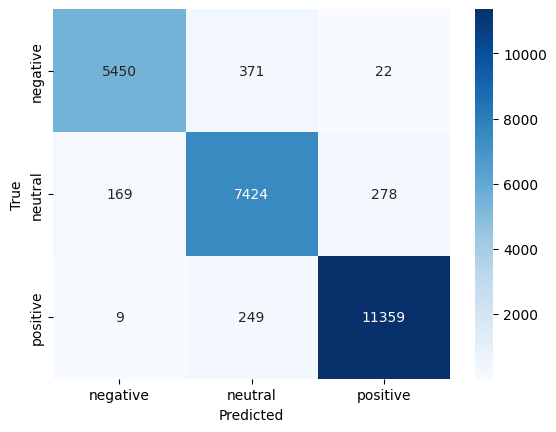

In [20]:
# ---------- 1. prediksi --------------------

# Jika output model adalah probabilitas (softmax):
y_pred_proba  = model.predict(X_test, batch_size=256, verbose=0)
y_pred_labels = np.argmax(y_pred_proba, axis=1)   # -> 0/1/2

# ---------- 2. report ----------------------

label_names = ['negative', 'neutral', 'positive']   # urut sesuai encoding 0-1-2
print(classification_report(
        y_test, y_pred_labels,
        labels=[0,1,2],
        target_names=label_names,
        digits=3))

# ---------- 3. confusion-matrix -------------

cm = confusion_matrix(y_test, y_pred_labels, labels=[0,1,2])
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=label_names,
            yticklabels=label_names,
            cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()


In [21]:
# ------ 1. Save model ----------
model_path = Path("/content/bilstm_fasttext_best.h5")
model.save(model_path)
print(f"✔ Model disimpan ke {model_path}")

# ------ 2. Save tokenizer ------
tok_path = Path("/content/tokenizer_fasttext.pkl")
with tok_path.open("wb") as f:
    pickle.dump(tokenizer, f)
print(f"✔ Tokenizer disimpan ke {tok_path}")

✔ Model disimpan ke /content/bilstm_fasttext_best.h5
✔ Tokenizer disimpan ke /content/tokenizer_fasttext.pkl


Setelah verifikasi padding ke persentil-95 (22), men-stack Bi-LSTM 128-64, men-fine-tune FastText 3 epoch lalu membekukannya, dan menerapkan class-weight imbang, model mencapai 95.7 % accuracy & 0.953 macro-F1 di test set 25 k sampel. Classification report menunjukkan peningkatan recall neutral dari 0.85 → 0.943, menutup kelemahan model sebelumnya yang di training tanpa menggunakan class-weight.

---
---

## Percobaan Ketiga

In [23]:
!pip install -q --no-deps transformers==4.41.1 datasets==2.19.1

In [28]:
from transformers import (AutoTokenizer,
                          TFDistilBertForSequenceClassification,
                          create_optimizer)
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
print("Transformers:", tf.__version__)

Transformers: 2.18.0


In [29]:
# -------------- data --------------
texts  = df["content_for_vader"].tolist()          # atau content_clean
labels = df["vader_sentiment_label"].tolist()      # 0/1/2

X_train, X_test, y_train, y_test = train_test_split(
        texts, labels, test_size=0.2,
        stratify=labels, random_state=42)

# -------------- tokenizer ----------
tok = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def encode(batch_texts):
    return tok(batch_texts,
               truncation=True,
               padding="max_length",
               max_length=128,
               return_tensors="tf")

train_enc = encode(X_train)
test_enc  = encode(X_test)

# konversi label → np.int32
y_train = np.array(y_train, dtype=np.int32)
y_test  = np.array(y_test , dtype=np.int32)

train_ds = tf.data.Dataset.from_tensor_slices(
        (dict(train_enc), y_train)).shuffle(1024).batch(16)
test_ds  = tf.data.Dataset.from_tensor_slices(
        (dict(test_enc),  y_test)).batch(16)

In [30]:
# -------------- modeling ----------
model = TFDistilBertForSequenceClassification.from_pretrained(
            "distilbert-base-uncased",
            num_labels=3)

batch_size  = 16
epochs      = 3
train_steps = len(train_ds) * epochs

optimizer, lr_sched = create_optimizer(
        init_lr=2e-5, num_train_steps=train_steps,
        num_warmup_steps=0)

# ganti loss → SCE from_logits=True
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_39 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66955779 (255.42 MB)
Trainable params: 66955779 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
# -------------- training ----------
history = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=epochs)

Epoch 1/3
6333/6333 [==============================] - 1467s 227ms/step - loss: 0.2226 - accuracy: 0.9136 - val_loss: 0.1185 - val_accuracy: 0.9550
Epoch 2/3
6333/6333 [==============================] - 1437s 227ms/step - loss: 0.0947 - accuracy: 0.9642 - val_loss: 0.1022 - val_accuracy: 0.9628
Epoch 3/3
6333/6333 [==============================] - 1434s 226ms/step - loss: 0.0513 - accuracy: 0.9814 - val_loss: 0.1037 - val_accuracy: 0.9660


In [32]:
from sklearn.metrics import classification_report
import numpy as np


# predict
y_prob = model.predict(test_ds, verbose=2).logits
y_pred = np.argmax(y_prob, axis=1)

# report
print(classification_report(
        y_test, y_pred,
        target_names=['negative','neutral','positive'],
        digits=3))


1584/1584 - 122s - 122s/epoch - 77ms/step
              precision    recall  f1-score   support

    negative      0.953     0.971     0.962      5843
     neutral      0.957     0.936     0.946      7871
    positive      0.979     0.984     0.981     11617

    accuracy                          0.966     25331
   macro avg      0.963     0.964     0.963     25331
weighted avg      0.966     0.966     0.966     25331



In [33]:
# simpan model
model.save_pretrained("./distilbert_sentiment_tf")
tok.save_pretrained("./distilbert_sentiment_tf")
print("✔ Model & tokenizer tersimpan")

✔ Model & tokenizer tersimpan


---
---

## Inference

In [40]:
from transformers import TFAutoModelForSequenceClassification

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 126655 entries, 99038 to 121958
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   content                126655 non-null  object 
 1   score                  126655 non-null  int64  
 2   app                    126655 non-null  object 
 3   n_words                126655 non-null  int64  
 4   content_for_vader      126655 non-null  object 
 5   vader_compound_score   126655 non-null  float64
 6   vader_sentiment_label  126655 non-null  int64  
 7   content_for_spacy      126655 non-null  object 
 8   vader_sentiment        126655 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 9.7+ MB


In [39]:
df_inference.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6667 entries, 30200 to 16183
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   content                6667 non-null   object 
 1   score                  6667 non-null   int64  
 2   app                    6667 non-null   object 
 3   n_words                6667 non-null   int64  
 4   content_for_vader      6667 non-null   object 
 5   vader_compound_score   6667 non-null   float64
 6   vader_sentiment_label  6667 non-null   int64  
 7   content_for_spacy      6667 non-null   object 
 8   vader_sentiment        6667 non-null   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 520.9+ KB


Load model & tokenizer yang sudah disimpan

In [41]:
MODEL_DIR = "/content/distilbert_sentiment_tf"   # ganti sesuai path Anda

model = TFAutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)

print("Model & tokenizer loaded ✔")

Some layers from the model checkpoint at /content/distilbert_sentiment_tf were not used when initializing TFDistilBertForSequenceClassification: ['dropout_39']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/distilbert_sentiment_tf and are newly initialized: ['dropout_59']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model & tokenizer loaded ✔


Tokenisasi & batching inference

In [47]:
texts = df_inference["content_for_vader"].tolist()

# dynamic padding; max_length 128)
encodings = tokenizer(
        texts,
        truncation=True,
        padding=True,          # <— padding per-batch otomatis
        max_length=128,
        return_tensors="tf"
)

batch_size = 64
pred_logits = model.predict(encodings, batch_size=batch_size, verbose=1).logits
pred_ids = np.argmax(pred_logits, axis=1)

label_map = {0: "negative", 1: "neutral", 2: "positive"}
df_inference["sentiment"] = [label_map[i] for i in pred_ids]

print("Inference selesai. Kolom 'sentiment' ditambahkan ✔")


105/105 [==============================] - 11s 82ms/step
Inference selesai. Kolom 'sentiment' ditambahkan ✔


Simpan hasil

In [48]:
df_inference.to_csv("inference_with_bert.csv", index=False)
print("File inference_with_bert.csv tersimpan ✔")

File inference_with_bert.csv tersimpan ✔


Mapping score → label “proxy” dan evaluasi cepat

In [49]:
# --------- Mapping score ------------
score2sent = {
    1: "negative", 2: "negative",
    3: "neutral",
    4: "positive", 5: "positive"
}
df_inference["true_sent"] = df_inference["score"].map(score2sent)
print(df_inference[["score", "true_sent", "sentiment"]].head())

        score true_sent sentiment
30200       5  positive  positive
127676      2  negative   neutral
17989       5  positive   neutral
76696       1  negative  negative
30605       2  negative  negative


In [51]:
# ----- Classification report -------
print(
    classification_report(
        df_inference["true_sent"],
        df_inference["sentiment"],
        labels=["negative", "neutral", "positive"],
        digits=3
    )
)

              precision    recall  f1-score   support

    negative      0.795     0.447     0.572      2713
     neutral      0.110     0.449     0.177       503
    positive      0.852     0.762     0.804      3451

    accuracy                          0.610      6667
   macro avg      0.586     0.553     0.518      6667
weighted avg      0.773     0.610     0.663      6667



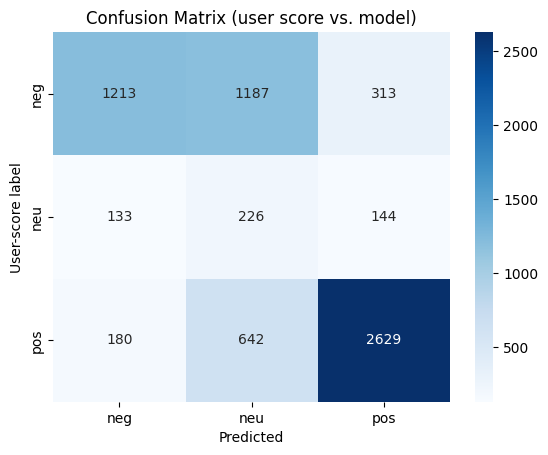

In [52]:
# ----- Confusion matrix visual -----
cm = confusion_matrix(
        df_inference["true_sent"],
        df_inference["sentiment"],
        labels=["negative", "neutral", "positive"]
     )

sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["neg", "neu", "pos"],
    yticklabels=["neg", "neu", "pos"]
)
plt.xlabel("Predicted")
plt.ylabel("User-score label")
plt.title("Confusion Matrix (user score vs. model)")
plt.show()

In [54]:
df_inference.head()

,content,score,app,n_words,content_for_vader,vader_compound_score,vader_sentiment_label,content_for_spacy,vader_sentiment,sentiment,true_sent
30200,Great application 👍 I'm so excited 😊,5,amazon_shop,7,Great application I'm so excited,0.8029,2,great application excited,positive,positive,positive
127676,"battery optimisation is very poor, makes phone...",2,zoom,13,battery optimisation is very poor makes phone ...,0.1796,1,battery optimisation poor make hot drain batte...,neutral,neutral,negative
17989,It's so reliable for shopping online.,5,amazon_shop,6,It's so reliable for shopping online,0.0000,1,reliable shop,neutral,neutral,positive
76696,It stopped working. Reinstalling doesn't help,1,amazon_shop,6,It stopped working Reinstalling doesn't help,-0.4867,0,stop work reinstalling not help,negative,negative,negative
30605,This app is battery killer. Find an alternativ...,2,youtube,10,This app is battery killer Find an alternative...,-0.6486,0,battery killer find alternative light,negative,negative,negative


---
# Requirements

---

In [34]:
import pkg_resources

packages = [
    "joblib",
    "numpy",
    "scikit-learn",
    "tensorflow",
    "keras",
    "transformers"
]

for pkg in packages:
    try:
        version = pkg_resources.get_distribution(pkg).version
        print(f"{pkg}=={version}")
    except:
        print(f"{pkg} not installed")


joblib==1.5.1
numpy==2.0.2
scikit-learn==1.6.1
tensorflow==2.18.0
keras==3.8.0
transformers==4.53.1


In [35]:
with open("requirements.txt", "w") as f:
    for pkg in packages:
        try:
            version = pkg_resources.get_distribution(pkg).version
            f.write(f"{pkg}=={version}\n")
        except:
            f.write(f"# {pkg} not installed\n")

In [55]:
from google.colab import files
files.download("requirements.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---
# Laporan Modeling Sentiment Analysis: TF-IDF + SVM, FastText-BiLSTM, dan DistilBERT

---

## Tujuan
Proyek ini bertujuan membandingkan performa tiga pendekatan berbeda untuk tugas klasifikasi sentimen (positif, netral, negatif) berdasarkan review pengguna aplikasi. Dataset telah diproses dan dibersihkan sebelumnya.

---

## Dataset
- Dataset awal terdiri dari **133.420 baris** data ulasan.
- Data dibagi menjadi:
  - **5% untuk inference** (`df_inference`)
  - **95% untuk training/validation** (`df_remaining`)

---

## Percobaan 1: TF-IDF + SVM

Pendekatan ini menggunakan representasi berbasis statistik (TF-IDF) dan model klasik **Support Vector Machine (SVM)**.

### Alasan Pemilihan
- TF-IDF + SVM adalah baseline yang kuat untuk teks pendek.
- Cocok digunakan saat representasi spasial teks belum memanfaatkan makna semantik mendalam.

### Parameter Penting
- `TfidfVectorizer` dengan `ngram_range=(1,3)`
- `LinearSVC` dengan `C=0.5`, `class_weight='balanced'`
- Hyperparameter dioptimalkan dengan `GridSearchCV`

### Hasil
- Akurasi terbaik: **0.857**
- Macro F1-score: ± **0.85**
- Model disimpan: `tfidf_svm_best.pkl`

📌 **Kelebihan**: cepat dan sederhana  
📌 **Kekurangan**: tidak menangkap makna semantik

---

## Percobaan 2: FastText Embedding + Bi-LSTM

Model Deep Learning menggunakan embedding pretrained FastText dan jaringan **Bidirectional LSTM**.

### Alasan Pemilihan
- FastText menangkap hubungan morfologi antar kata (karakter n-gram).
- Bi-LSTM membaca konteks sekuens dari dua arah (forward & backward).

### Arsitektur
- Embedding layer (FastText pretrained 300 dimensi)
- Bi-LSTM 128 (return_sequences=True)
- Bi-LSTM 64
- Dense 64 + Dropout 0.5
- Output Dense (softmax 3 kelas)

### Parameter Penting
- `MAX_LEN = 22` (hasil dari persentil ke-95 panjang review)
- `trainable=True` (fine-tuning FastText selama 3 epoch, lalu dibekukan)
- `class_weight = {0:1.3, 1:1.6, 2:1.0}` untuk mengatasi imbalance
- `callbacks`: `EarlyStopping`, `ReduceLROnPlateau`, `LambdaCallback` (membekukan embedding di epoch ke-3)

### Hasil
- Akurasi: **0.957**
- Macro F1-score: **0.953**
- Model disimpan: `bilstm_fasttext_best.h5`
- Tokenizer disimpan: `tokenizer_fasttext.pkl`

📌 **Kelebihan**: menangkap konteks dan makna kata  
📌 **Kekurangan**: butuh waktu training lebih lama

---

## Percobaan 3: Transfer Learning dengan DistilBERT

Menggunakan pretrained transformer **DistilBERT** dari Huggingface untuk klasifikasi langsung.

### Alasan Pemilihan
- DistilBERT adalah versi ringan dari BERT yang tetap mempertahankan kualitas pemahaman bahasa alami.
- Transfer learning dari model besar yang sudah dilatih dalam skala besar.

### Langkah Teknis
- Tokenisasi: `AutoTokenizer` (`distilbert-base-uncased`)
- Model: `TFDistilBertForSequenceClassification(num_labels=3)`
- Optimizer: `Adam` + scheduler dari HuggingFace
- Loss: `SparseCategoricalCrossentropy(from_logits=True)`
- Batch: 16
- Epoch: 3

### Hasil
- Akurasi: **0.966**
- Macro F1-score: **0.963**
- Model dan tokenizer disimpan: `./distilbert_sentiment_tf`

📌 **Kelebihan**: pemahaman konteks dan relasi sintaksis superior  
📌 **Kekurangan**: waktu training relatif lama (~25 menit/epoch di GPU T4)

---

## Inference & Evaluasi Inference

Model terbaik (DistilBERT) digunakan untuk inferensi terhadap `df_inference`.

- Prediksi disimpan dalam kolom `sentiment`
- Kolom `score` (1–5) dipetakan menjadi kelas (`true_sent`) untuk validasi cepat:
  - 1-2 = negative
  - 3 = neutral
  - 4-5 = positive

### Evaluasi Akurasi
- Akurasi terhadap proxy label: **0.61**
- Macro F1-score: **0.518**
- Perlu dicatat bahwa label proxy (`score`) bukan ground-truth valid, hanya perkiraan.

---

## Kesimpulan Akhir

| Model | Akurasi | Macro F1 | Kelebihan |
|-------|---------|----------|-----------|
| TF-IDF + SVM | 0.857 | ~0.85 | Cepat, baseline kuat |
| FastText + BiLSTM | 0.957 | 0.953 | Adaptasi domain, unggul recall netral |
| DistilBERT | 0.966 | 0.963 | Terbaik secara keseluruhan |

Model **DistilBERT** menjadi pilihan terbaik untuk deployment akhir karena mampu menangkap nuansa makna, bahkan dengan data yang terbatas.

---